# Setup Environment

In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-j90w62l3
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-j90w62l3
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-4bad5q84/pyfolio_d12058fe4a534f7baa2807ff66720416
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-4bad5q84/pyfolio_d12058fe4a534f7baa2807ff66720416
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-4bad5q84/elegantrl_38e3f3e0598b4b6ab8b65b2d535e3cc2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-4bad5q84/elegantrl_38e3f3e0598b4b6ab8b65b2d535e3cc2


In [1]:
import sys
sys.path.append("../FinRL-Library")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline
import datetime


from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
"https://github.com/AI4Finance-Foundation/FinRL/issues/372"

from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts



/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Data overview
(i) assets universe: 30 components of DJIA 

(ii) frequency of the data: Daily
size of the universe: ~10 years*30 instruments (now we only use 3 years, 2 yr for training, 1 yr for testing); "YahooDownloader(start_date,end_date,..)", "train = data_split(..)"

length of the rolling window: 252 days; "lookback"

rebalancing frequency: daily

any investment constraints: Only buy/sell/hold 
and no maximum stock holding 
constraint: hmax=100 (which is greater than max. number of assets universe30)

In [4]:
# df = YahooDownloader(start_date = '2017-01-01',
#                      end_date = '2021-11-03',
#                      ticker_list = ["AAPL","TSLA"]).fetch_data()
df = YahooDownloader(start_date = '2017-01-01',
                     end_date = '2021-11-03',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

# df.save_csv("data.csv")
# df = pd.read_csv("data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [7]:
df

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2017-01-03,28.950001,29.082500,28.690001,27.332468,115127600,AAPL,1,0.000000,27.360432,27.273916,0.000000,66.666667,100.000000,27.332468,27.332468
1218,2017-01-03,147.860001,151.000000,147.119995,130.481018,3640901,AMGN,1,0.000000,27.360432,27.273916,0.000000,66.666667,100.000000,130.481018,130.481018
2436,2017-01-03,74.889999,75.750000,74.739998,69.956383,5854149,AXP,1,0.000000,27.360432,27.273916,0.000000,66.666667,100.000000,69.956383,69.956383
3654,2017-01-03,156.300003,157.139999,155.210007,145.533676,3426124,BA,1,0.000000,27.360432,27.273916,0.000000,66.666667,100.000000,145.533676,145.533676
4872,2017-01-03,94.000000,95.190002,93.250000,82.524055,5054900,CAT,1,0.000000,27.360432,27.273916,0.000000,66.666667,100.000000,82.524055,82.524055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30449,2021-11-02,456.260010,456.440002,450.380005,450.570435,2600121,UNH,1,12.770611,473.794403,385.684347,62.627164,103.018000,53.248393,419.117686,416.902421
31667,2021-11-02,213.160004,213.350006,207.820007,208.772476,14688722,V,1,-3.832547,241.212785,207.683974,39.143645,-211.418550,39.866563,225.056474,226.840765
32885,2021-11-02,53.049999,53.090000,52.509998,52.570000,16913800,VZ,1,-0.177874,54.169688,51.217313,44.568837,-41.599978,12.106220,53.022497,53.692444
34103,2021-11-02,47.540001,47.770000,46.849998,47.293438,5059299,WBA,1,-0.218640,49.534833,45.617586,48.129624,-48.759856,5.831506,47.498790,48.126209


In [8]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [9]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=60
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [10]:
# train = data_split(df, '2019-01-01','2020-12-31')
train = data_split(df, '2017-01-01','2020-12-31')

Technical indicator review:
MACD: macd
Boll: boll_ub	boll_lb	
RSI: rsi_30	
CCI: cci_30	
DX: dx_30	
SMA: close_30_sma	close_60_sma	

In [11]:
train.head()

,date,open,high,low,close,volume,tic,day,macd_x,boll_ub_x,boll_lb_x,rsi_30_x,cci_30_x,dx_30_x,close_30_sma_x,close_60_sma_x,macd_y,boll_ub_y,boll_lb_y,rsi_30_y,cci_30_y,dx_30_y,close_30_sma_y,close_60_sma_y,cov_list,return_list
0,2017-03-30,36.047501,36.125000,35.875000,34.016514,84829200,AAPL,3,0.518829,34.013956,32.440324,76.617936,184.539631,47.512885,32.950148,31.091328,0.518829,34.013956,32.440324,76.617936,184.539631,47.512885,32.950148,31.091328,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
0,2017-03-30,164.070007,164.800003,163.210007,143.278702,2262328,AMGN,3,-1.891554,163.507888,138.080807,47.237200,-121.973771,35.159492,151.336643,144.660750,-1.891554,163.507888,138.080807,47.237200,-121.973771,35.159492,151.336643,144.660750,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
0,2017-03-30,78.199997,79.300003,78.089996,73.853729,2923664,AXP,3,-0.169611,74.977161,72.116782,54.177337,-45.315177,0.609347,73.929249,72.921968,-0.169611,74.977161,72.116782,54.177337,-45.315177,0.609347,73.929249,72.921968,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
0,2017-03-30,177.250000,178.490005,177.220001,166.432388,1737221,BA,3,0.740446,170.877458,163.464779,60.765065,-11.690482,4.214197,166.784602,158.866134,0.740446,170.877458,163.464779,60.765065,-11.690482,4.214197,166.784602,158.866134,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
0,2017-03-30,92.980003,93.370003,92.400002,82.527130,3672600,CAT,3,-0.611209,84.829144,80.051586,48.256444,-48.856684,9.857228,83.628431,83.740226,-0.611209,84.829144,80.051586,48.256444,-48.856684,9.857228,83.628431,83.740226,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...


# Stock training enviroment
State: "self.state = np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)"

Action: [0,1]x30 "self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))"

Reward: Cumulative return of portfolio

In [12]:
# import numpy as np
# import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)


            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            print("Step reward: ", self.reward)
            self.reward = self.reward*self.reward_scaling
            # Test
            # self.reward = -self.reward

            # TODO:　CHANGE REWARD FUNCTION TO GBI FUNCTION:
            # Pr[Wj(t + h)| Wi(t), I(t)]? 
            # CHANGED REWARD FN
            # df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            # df_daily_return.columns = ['daily_return']
            # if df_daily_return['daily_return'].std() !=0:
            #   sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
            #            df_daily_return['daily_return'].std()
            # self.reward = sharpe 
            # self.reward = 1

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [13]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 29


In [14]:
train.tic.unique()

array(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
       'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'],
      dtype=object)

In [15]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
df.head()

,date,open,high,low,close,volume,tic,day,macd_x,boll_ub_x,boll_lb_x,rsi_30_x,cci_30_x,dx_30_x,close_30_sma_x,close_60_sma_x,macd_y,boll_ub_y,boll_lb_y,rsi_30_y,cci_30_y,dx_30_y,close_30_sma_y,close_60_sma_y,cov_list,return_list
0,2017-03-30,36.047501,36.125000,35.875000,34.016514,84829200,AAPL,3,0.518829,34.013956,32.440324,76.617936,184.539631,47.512885,32.950148,31.091328,0.518829,34.013956,32.440324,76.617936,184.539631,47.512885,32.950148,31.091328,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
1,2017-03-30,164.070007,164.800003,163.210007,143.278702,2262328,AMGN,3,-1.891554,163.507888,138.080807,47.237200,-121.973771,35.159492,151.336643,144.660750,-1.891554,163.507888,138.080807,47.237200,-121.973771,35.159492,151.336643,144.660750,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
2,2017-03-30,78.199997,79.300003,78.089996,73.853729,2923664,AXP,3,-0.169611,74.977161,72.116782,54.177337,-45.315177,0.609347,73.929249,72.921968,-0.169611,74.977161,72.116782,54.177337,-45.315177,0.609347,73.929249,72.921968,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
3,2017-03-30,177.250000,178.490005,177.220001,166.432388,1737221,BA,3,0.740446,170.877458,163.464779,60.765065,-11.690482,4.214197,166.784602,158.866134,0.740446,170.877458,163.464779,60.765065,-11.690482,4.214197,166.784602,158.866134,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...
4,2017-03-30,92.980003,93.370003,92.400002,82.527130,3672600,CAT,3,-0.611209,84.829144,80.051586,48.256444,-48.856684,9.857228,83.628431,83.740226,-0.611209,84.829144,80.051586,48.256444,-48.856684,9.857228,83.628431,83.740226,"[[9.565024824966285e-05, 4.423782021086738e-05...",tic AAPL AMGN AXP ... ...


In [18]:
env_kwargs = {
    "hmax": 5, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

KeyError: ignored

In [24]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## Parameter Check

In [25]:
e_train_gym.portfolio_value

1000000

In [26]:
e_train_gym.lookback

252

<a id='5'></a>
# Training with different models: A2C, PPO, DDPG

In [27]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [ ]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


total_timesteps=50,000

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=5000)

Streaming output truncated to the last 5000 lines.
Step reward:  1174360.0166188516
Step reward:  1187070.528040741
Step reward:  1185128.106958104
Step reward:  1187953.8443967148
Step reward:  1180984.268313871
Step reward:  1185895.2923727273
Step reward:  1182208.8418059046
Step reward:  1182888.8094296262
Step reward:  1183336.6020537482
Step reward:  1193426.977354364
Step reward:  1199605.916691543
Step reward:  1199048.8030901165
Step reward:  1204229.1478975178
Step reward:  1198294.9609687743
Step reward:  1208285.7628809828
Step reward:  1213050.3178729233
Step reward:  1214249.3379642454
Step reward:  1214762.5521956393
Step reward:  1220461.2526015823
Step reward:  1223071.2186817252
Step reward:  1221687.9339814787
Step reward:  1224254.5311207224
Step reward:  1231813.3746362322
Step reward:  1227571.7608782318
Step reward:  1235811.578656259
Step reward:  1236803.2216097359
Step reward:  1236506.1674413087
Step reward:  1230635.1131549086
Step reward:  1228423.368661817

In [ ]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

In [34]:
trade = data_split(df,'2021-01-01', '2021-11-03')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

df_daily_return_a2c_load, df_daily_return_a2c_load = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

NameError: ignored

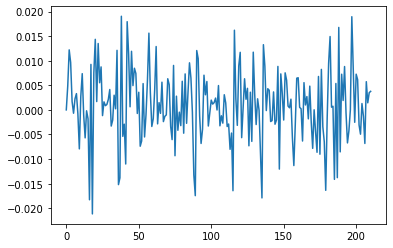

In [ ]:
%matplotlib inline
plt.plot(df_daily_return_a2c["daily_return"])

### Model 2: **PPO**


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

In [ ]:
trained_ppo.save('/content/trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

In [ ]:
trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

## Load model

In [38]:
# Load model
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
cwd = "/content/trained_models/trained_a2c.zip"
trained_a2c_load = MODELS["a2c"].load(cwd)

df_daily_return_a2c_load, df_actions_a2c_load = DRLAgent.DRL_prediction(model=trained_a2c_load,
                        environment = e_trade_gym)

Step reward:  1005246.0830769503
Step reward:  1020068.409931012
Step reward:  1025618.4056138274
Step reward:  1028179.8177591152
Step reward:  1026872.5819318682
Step reward:  1030364.2502398732
Step reward:  1034822.4316732618
Step reward:  1034571.5488157894
Step reward:  1027804.8733217018
Step reward:  1031031.0532584055
Step reward:  1039593.9840098558
Step reward:  1037546.0742384497
Step reward:  1029641.2562969666
Step reward:  1030068.1650246854
Step reward:  1029478.8486528177
Step reward:  1008727.7291077961
Step reward:  1019715.9611827332
Step reward:  998691.804801159
Step reward:  1006756.5558148831
Step reward:  1020007.8732513906
Step reward:  1020520.6611217624
Step reward:  1034312.4548378319
Step reward:  1038361.3938843716
Step reward:  1046049.4596046639
Step reward:  1045270.1682213407
Step reward:  1043813.2220445884
Step reward:  1043448.7088402553
Step reward:  1045536.5275107905
Step reward:  1044847.4620537485
Step reward:  1048181.0003339213
Step reward: 

## Back-Testing
Assume that we have $1,000,000 initial capital at 2021-01-01. We use the PPO, A2C.


In [ ]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 4.4 MB/s 
     |████████████████████████████████| 2.8 MB 23.5 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [106]:
trade = data_split(df,'2021-01-01', '2021-11-03')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

AttributeError: ignored

In [ ]:
import torch
%matplotlib inline
import plotly.express as px

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [ ]:
!pip install pyfolio

In [ ]:
import pyfolio
%matplotlib inline
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2021-01-01' ,
        end =  '2021-11-03')

baseline_df_stats = backtest_stats(baseline_df, value_col_name = 'close')
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

dji_cumpod =(baseline_returns+1).cumprod()-1

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (211, 8)
Annual return          0.234435
Cumulative returns     0.192852
Annual volatility      0.119134
Sharpe ratio           1.836369
Calmar ratio           4.688161
Stability              0.767978
Max drawdown          -0.050006
Omega ratio            1.358102
Sortino ratio          2.720657
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.098201
Daily value at risk   -0.014141
dtype: float64


In [ ]:
import pandas as pd
dfStore = pd.DataFrame()
dfStore["dji_cumpod"] = dji_cumpod.to_list()
dfStore.to_csv("dji_cumpod.csv")

In [ ]:
from pyfolio import timeseries

df_daily_return_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)
df_daily_return_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)
time_ind = pd.Series(df_daily_return_a2c.date)
a2c_cumpod =(df_daily_return_a2c.daily_return+1).cumprod()-1
ppo_cumpod =(df_daily_return_ppo.daily_return+1).cumprod()-1
DRL_strat_a2c = convert_daily_return_to_pyfolio_ts(df_daily_return_a2c)
DRL_strat_ppo = convert_daily_return_to_pyfolio_ts(df_daily_return_ppo)

perf_func = timeseries.perf_stats 
perf_stats_all_a2c = perf_func( returns=DRL_strat_a2c, 
                              factor_returns=DRL_strat_a2c, 
                                positions=None, transactions=None, turnover_denom="AGB")
perf_stats_all_ppo = perf_func( returns=DRL_strat_ppo, 
                              factor_returns=DRL_strat_ppo, 
                                positions=None, transactions=None, turnover_denom="AGB")

NameError: ignored

In [ ]:
def extract_weights(drl_actions_list):
  a2c_weight_df = {'date':[], 'weights':[]}
  for i in range(len(drl_actions_list)):
    date = drl_actions_list.index[i]
    tic_list = list(drl_actions_list.columns)
    weights_list = drl_actions_list.reset_index()[list(drl_actions_list.columns)].iloc[i].values
    weight_dict = {'tic':[], 'weight':[]}
    for j in range(len(tic_list)):
      weight_dict['tic'] += [tic_list[j]]
      weight_dict['weight'] += [weights_list[j]]

    a2c_weight_df['date'] += [date]
    a2c_weight_df['weights'] += [pd.DataFrame(weight_dict)]

  a2c_weights = pd.DataFrame(a2c_weight_df)
  return a2c_weights

a2c_weights = extract_weights(df_actions_a2c)
ppo_weights = extract_weights(df_actions_ppo)

NameError: ignored

In [ ]:
a2c_weights['weights'] #how to store objects?

NameError: ignored

In [ ]:
dfStore = pd.DataFrame()
dfStore["a2c_cumpod"] = a2c_cumpod
dfStore["ppo_cumpod"] = ppo_cumpod
dfStore["dji_cumpod"] = dji_cumpod
dfStore["time_ind"] = time_ind
dfStore.to_csv("cumpod.csv")

In [ ]:
dfStore.head()

,a2c_cumpod,ppo_cumpod,dji_cumpod,time_ind
0,0.000000,0.000000,NaN,2021-01-04
1,0.006154,0.003327,NaN,2021-01-05
2,0.017180,0.015401,NaN,2021-01-06
3,0.024699,0.023756,NaN,2021-01-07
4,0.027456,0.026627,NaN,2021-01-08


## Min-Variance Portfolio Allocation

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [ ]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2018-01-03,43.132500,43.637501,42.990002,41.180988,118071600,AAPL,2,0.098234,42.214665,40.072476,54.843989,31.939394,8.972581,41.156762,40.202938,"[[0.000123569434607133, 6.678262469243348e-05]...",tic AAPL TSLA date ...
1,2018-01-03,64.199997,65.050003,63.110001,63.450001,22607500,TSLA,2,-0.176505,69.620182,60.037219,47.351012,-3.539941,0.543318,64.000334,64.782567,"[[0.000123569434607133, 6.678262469243348e-05]...",tic AAPL TSLA date ...
2,2018-01-04,43.134998,43.367500,43.020000,41.372265,89738400,AAPL,3,0.109644,42.223359,40.144838,55.751924,26.640219,8.972581,41.181071,40.273665,"[[0.000123572291564027, 6.716526841352364e-05]...",tic AAPL TSLA date ...
3,2018-01-04,62.574001,63.709999,61.136002,62.924000,49731500,TSLA,3,-0.259604,69.427041,60.448760,46.537353,-48.291502,13.779265,64.039534,64.688167,"[[0.000123572291564027, 6.716526841352364e-05]...",tic AAPL TSLA date ...
4,2018-01-05,43.360001,43.842499,43.262501,41.843300,94640000,AAPL,4,0.154909,42.267713,40.243706,57.907949,81.866234,17.562463,41.195895,40.352006,"[[0.00012389912803703701, 6.738018136309224e-0...",tic AAPL TSLA date ...


In [ ]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [ ]:
portfolio.head()

,account_value
2021-01-04,1000000
2021-01-05,1.01219e+06
2021-01-06,980321
2021-01-07,1.01545e+06
2021-01-08,1.02679e+06


In [ ]:
a2c_cumpod =(df_daily_return_a2c.daily_return+1).cumprod()-1

In [ ]:
ppo_cumpod =(df_daily_return_ppo.daily_return+1).cumprod()-1

In [ ]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [ ]:
dji_cumpod =(baseline_returns+1).cumprod()-1

In [ ]:
# COMBINE THE PLOT
# from matplotlib import pyplot as plt
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True
# overlapping = 0.150
# line1 = plt.plot(a2c_cumpod, c='red', alpha=overlapping, lw=1)
# line2 = plt.plot(min_var_cumpod, c='green', alpha=overlapping,
# lw=1)
# line3 = plt.plot(dji_cumpod, c='yellow', alpha=overlapping,
# lw=1)
# plt.show()

### A2C Model - Cumulative Return

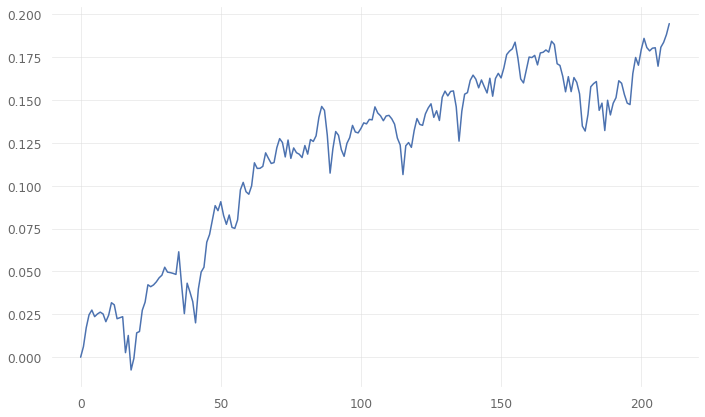

In [ ]:
plt.plot(a2c_cumpod)

### PPO Model - Cumulative Return


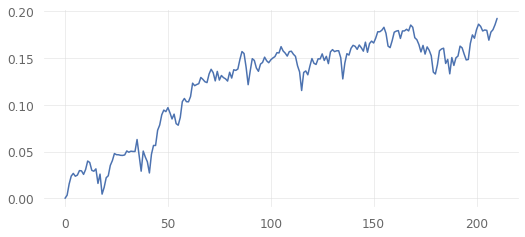

In [ ]:
plt.plot(ppo_cumpod)

### Min-Var Model - Cumulative Return


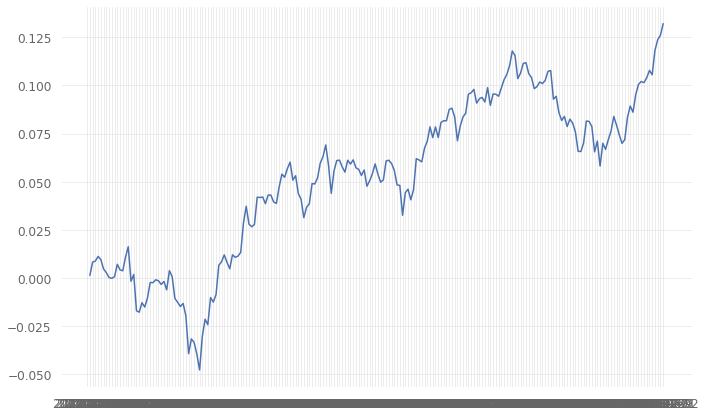

In [ ]:
plt.plot(min_var_cumpod)

### DJIA Model - Cumulative Return

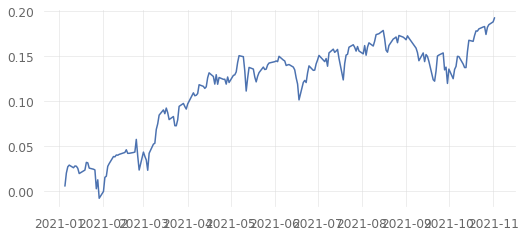

In [ ]:
plt.plot(dji_cumpod)

## Plotly: DRL, Min-Variance, DJIA TODO Quantstat

In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
time_ind = pd.Series(df_daily_return.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

# Plot by Quantstat

In [39]:
!pip install quantstats --upgrade --no-cache-dir

In [40]:
!pip install quantstats --upgrade --no-cache-dir
import pandas as pd
import pandas_datareader.data as pdr
import quantstats as qs

In [43]:
# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
# stock = qs.utils.download_returns('FB')
rlPort = pd.Series(df_daily_return_a2c_load["daily_return"])
rlPort.index = pd.DatetimeIndex(df_daily_return_a2c_load["date"])

# show sharpe ratio
qs.stats.sharpe(rlPort)

# or using extend_pandas() :)
rlPort.sharpe()

1.8966881860402178

In [51]:
df2 = df[df["tic"]=="AAPL"]

In [53]:
df2

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2018-01-03,43.132500,43.637501,42.990002,41.180992,118071600,AAPL,2,0.098233,42.214663,40.072474,54.844044,31.939616,8.972581,41.156761,40.202937,"[[0.00012356936201184124, 3.333107896019157e-0...",tic AAPL AMGN AXP ... ...
29,2018-01-04,43.134998,43.367500,43.020000,41.372272,89738400,AAPL,3,0.109644,42.223357,40.144837,55.752001,26.640633,8.972581,41.181069,40.273665,"[[0.00012357222110811537, 3.3421716649275477e-...",tic AAPL AMGN AXP ... ...
58,2018-01-05,43.360001,43.842499,43.262501,41.843311,94640000,AAPL,4,0.154910,42.267712,40.243707,57.908050,81.866688,17.562463,41.195894,40.352005,"[[0.00012389906074536895, 3.3620833349104506e-...",tic AAPL AMGN AXP ... ...
87,2018-01-08,43.587502,43.902500,43.482498,41.687889,82271200,AAPL,0,0.176212,42.276707,40.354980,56.960679,87.141388,18.599690,41.191031,40.425174,"[[0.00012366108486222457, 3.273870587792594e-0...",tic AAPL AMGN AXP ... ...
116,2018-01-09,43.637501,43.764999,43.352501,41.683113,86336000,AAPL,1,0.190512,42.267186,40.483099,56.931072,75.810581,15.241582,41.185931,40.500447,"[[0.00012344953439092567, 3.226446640675241e-0...",tic AAPL AMGN AXP ... ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27869,2021-10-27,149.360001,149.729996,148.490005,148.633087,56094900,AAPL,2,0.962954,151.583170,137.591791,54.555358,106.590127,7.588151,144.685504,147.043565,"[[0.0002795778815630524, 5.851831212612364e-05...",tic AAPL AMGN AXP ... ...
27898,2021-10-28,149.820007,153.169998,149.720001,152.347656,100077900,AAPL,3,1.309959,152.759070,137.521278,58.671041,166.699577,23.469447,144.811320,147.140754,"[[0.0002727963658441952, 5.279348079241102e-05...",tic AAPL AMGN AXP ... ...
27927,2021-10-29,147.220001,149.940002,146.410004,149.581696,124850400,AAPL,4,1.346254,153.251607,137.742700,54.844939,87.945874,4.922968,144.935806,147.190015,"[[0.00026921575666400045, 5.1922880679088116e-...",tic AAPL AMGN AXP ... ...
27956,2021-11-01,148.990005,149.699997,147.800003,148.742920,74588300,AAPL,0,1.292438,153.217778,138.757098,53.745433,83.720420,4.922968,145.136180,147.236947,"[[0.0002563175750611476, 5.061942183685823e-05...",tic AAPL AMGN AXP ... ...


In [44]:
df_actions_a2c.head()

NameError: ignored

In [133]:
df_actions_a2c.tail()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-27,0.060646,0.025417,0.069091,0.025417,0.025417,0.031223,0.033304,0.069091,0.028093,0.033995,0.053726,0.025417,0.034070,0.045172,0.025417,0.025417,0.025417,0.025417,0.025417,0.025417,0.025417,0.025417,0.025417,0.025417,0.032640,0.025417,0.025417,0.033183,0.069091
2021-10-28,0.026419,0.026419,0.026419,0.029420,0.026419,0.026419,0.026419,0.026419,0.071816,0.071816,0.026419,0.026419,0.026419,0.026419,0.026419,0.052069,0.026419,0.026419,0.071816,0.026419,0.026419,0.026419,0.026991,0.026419,0.026419,0.046234,0.044268,0.036552,0.047050
2021-10-29,0.043761,0.075117,0.045187,0.027634,0.027634,0.027634,0.075117,0.028696,0.027634,0.027634,0.035436,0.027634,0.027634,0.027634,0.027634,0.027634,0.027634,0.027634,0.037623,0.027634,0.035603,0.027634,0.044912,0.027634,0.027634,0.027634,0.027634,0.053504,0.027634
2021-11-01,0.028980,0.028980,0.028980,0.046217,0.035069,0.028980,0.028980,0.056467,0.033355,0.038392,0.032824,0.028980,0.028980,0.028980,0.028980,0.028980,0.040541,0.028980,0.078775,0.028980,0.031543,0.028980,0.051262,0.028980,0.028980,0.028980,0.033628,0.028980,0.029273
2021-11-02,0.045228,0.024485,0.024485,0.024485,0.066557,0.024485,0.024485,0.028046,0.066557,0.024485,0.024485,0.026676,0.066557,0.024485,0.024485,0.024485,0.030506,0.032602,0.024485,0.024485,0.066557,0.024485,0.053271,0.024485,0.024485,0.034646,0.024485,0.024485,0.066557


In [45]:
len(rlPort)

211

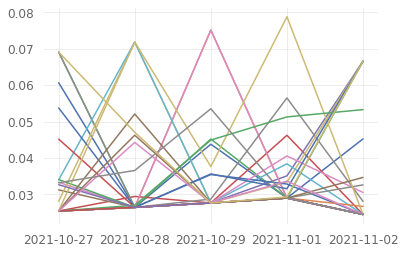

In [ ]:
plt.plot(df_actions_a2c.tail())

In [47]:
qs.reports.html(rlPort, "DJIA",output="report.html")